## Imports

In [10]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import os
import time
from datetime import timedelta
import pickle

/Users/lzcai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set Parameter

In [11]:
# Initialize Values
NUM_FEATURES = 36
NUM_CLASSES = 6
NUM_HIDDEN = 10

LEARNING_RATE = 0.01
EPOCHS = 5000
BATCH_SIZE = 32
SEED = 10
BETA = pow(10, -6)
np.random.seed(SEED)
DROP = True

TRAIN_FILE_NAME = 'sat_train.txt'
TEST_FILE_NAME = 'sat_test.txt'

## Load Data

In [12]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

def process_inputs_from_file(fileName): # Read in data
    inputs = np.loadtxt(fileName, delimiter=' ')
    X, _Y = inputs[:, :NUM_FEATURES], inputs[:, -1].astype(int)
    X = scale(X, np.min(X, axis=0), np.max(X, axis=0))
    _Y[_Y == 7] = 6 # Actually dont have, just in case have error data

    Y = np.zeros((_Y.shape[0], NUM_CLASSES))
    Y[np.arange(_Y.shape[0]), _Y - 1] = 1 #one hot matrix
    return X, Y

In [13]:
trainX, trainY = process_inputs_from_file(TRAIN_FILE_NAME)
testX, testY = process_inputs_from_file(TEST_FILE_NAME)

In [14]:
print ("Size of:")
print("- Training-set\t\t",len(trainX))
print("- Test-set\t\t",len(testX))

Size of:
- Training-set		 4435
- Test-set		 2000


## Tensorflow Graph

There are 3 layers in this graph, namely one input-layer(X), one hidden-layer(W, b) and one output-layer(V, c).

The output does not scale to [0, 1] and I dont know why. --- Solved 07 Oct.

### Placeholder Variables

In [15]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES], name='x')
d = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='d')

### Create Network

In [16]:
def init_weights(feature_no, neuron_no, name, logistic = True):
    # From eg.5.2
    n_in = feature_no
    n_out = neuron_no
    W_values = np.asarray(np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                            high=np.sqrt(6. / (n_in + n_out)),
                                            size=(n_in, n_out)))
    if logistic == True:
        W_values *= 4
    return(tf.Variable(W_values, dtype=tf.float32, name=name))

def init_bias(neuron_no, name):
    # From eg.5.2
    return(tf.Variable(np.zeros(neuron_no), dtype=tf.float32, name=name))

In [17]:
with tf.variable_scope("Hidden_layer"):
    W = init_weights(NUM_FEATURES, NUM_HIDDEN, name="Weight_1")
    b = init_bias(NUM_HIDDEN, name="Bias_1")
    z = tf.matmul(x, W) + b #syn_input_1
    h = tf.nn.sigmoid(z) #out_1

with tf.variable_scope("Output_layer"):
    V = init_weights(NUM_HIDDEN, NUM_CLASSES, name="Weight_2")
    c = init_bias(NUM_CLASSES, name="Bias_2" )
    u = tf.matmul(h, V) + c #syn_out_2
    y = tf.nn.sigmoid(u) #out_2  # Consider to change to sigmoid

### Performance Measures

In [18]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [19]:
cross_entropy = setup_cross_entropy(labels=d, logits=y)
regularization = tf.nn.l2_loss(V) + tf.nn.l2_loss(W) 
J = tf.reduce_mean(cross_entropy + BETA * regularization)

In [20]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

### Optimization Method

In [21]:
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(J)

### Saver

In [23]:
saver = tf.train.Saver()

In [24]:
# save_dir = "Z:\Github\CZ4042\save"
save_dir = "/Users/lzcai/CZ4042 Project/CZ4042/save-mac"
if not os.path.exists(save_dir):
    print("Not Exist")
    os.makedirs(save_dir)

Not Exist


In [25]:
drop_str = "-Drop" if DROP else "-Not_Drop"

save_path = os.path.join(save_dir, str(EPOCHS)+ '-'+ str(BATCH_SIZE)+'-sigmoid')

In [26]:
save_path

'/Users/lzcai/CZ4042 Project/CZ4042/save-mac/5000-32-sigmoid'

## TensorFlow Run

### Create TensorFlow Session

In [27]:
session = tf.Session()

### Initialize variables

In [28]:
def init_variables():
    session.run(tf.global_variables_initializer())

In [29]:
init_variables()

### Helper-function to perform optimization iterations

### Helper-function to generate next_batch

In [30]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Helper-function to plot train accuracy

In [31]:
def plot_train(EPOCHS, BATCH_SIZE, train_acc_record, error=False):
    if error:
        train_acc_record = [1-tmp for tmp in train_acc_record]
        yLabel = "Train Error"
    else:
        yLabel = 'Train Accuracy'
        
    plt.figure(1)
    plt.plot(range(EPOCHS), train_acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel(yLabel)
    plt.savefig("PartA-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png")
    plt.show()

        

In [32]:
def plot_test(EPOCHS, BATCH_SIZE, test_acc_record, error=False):
    if error:
        test_acc_record = [1-tmp for tmp in test_acc_record]
        yLabel = "Test Error"
    else:
        yLabel = 'Test Accuracy'
    
    plt.figure(1)
    plt.plot(range(EPOCHS), test_acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel('Test accuracy')
    plt.savefig("PartA-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png")
    plt.show()

In [34]:
# ========== For test after training only- =========== #
# plot_train(EPOCHS, BATCH_SIZE, train_acc_record, test = True)
# plot_test(test_count, BATCH_SIZE, test_acc_record)

### Helper-function of validation

In [35]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

### RUN!!!!!

Find the optimal batch size by training the neural network by evaluating the performances for different batch sizes.

- Plot the **Training Errors** and **Test Accuracies** against the **number of epochs** for the 3-layer network for **different batch sizes**. Limit search space to *S={4, 8, 16, 32, 64}*.

- Plot the **time taken to train** the network for **one epoch** against **different batch sizes**

- State the rationale for selecting the optimal batch size

In [38]:
train_acc_backup = []
test_acc_backup = []
time_usage_backup = []
total_time_backup = []

BATCH_SIZE= 4
iter 0: Train accuracy 0.5 Test accuracy:  0.254 *
iter 100: Train accuracy 0.75 Test accuracy:  0.657 *
iter 200: Train accuracy 0.5 Test accuracy:  0.783 *
iter 300: Train accuracy 1 Test accuracy:  0.793 *
iter 400: Train accuracy 0.75 Test accuracy:  0.804 *
iter 500: Train accuracy 1 Test accuracy:  0.8085 *
iter 600: Train accuracy 1 Test accuracy:  0.809 *
iter 700: Train accuracy 0.75 Test accuracy:  0.812 *
iter 800: Train accuracy 1 Test accuracy:  0.8115 
iter 900: Train accuracy 1 Test accuracy:  0.8135 *
iter 1000: Train accuracy 0.75 Test accuracy:  0.8175 *
iter 1100: Train accuracy 0.75 Test accuracy:  0.8195 *
iter 1200: Train accuracy 0.75 Test accuracy:  0.818 
iter 1300: Train accuracy 0.75 Test accuracy:  0.823 *
iter 1400: Train accuracy 1 Test accuracy:  0.825 *
iter 1500: Train accuracy 0.75 Test accuracy:  0.8255 *
iter 1600: Train accuracy 1 Test accuracy:  0.8255 
iter 1700: Train accuracy 1 Test accuracy:  0.826 *
iter 1800: Train accuracy 1 Te

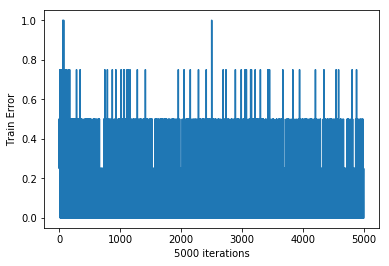

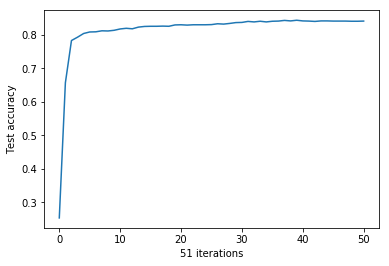

In [45]:
# for BATCH_SIZE in [64, 32, 16, 8, 4]:
for BATCH_SIZE in [4]:
# Counter for total number of iterations performed so far.
    init_variables()
    print("BATCH_SIZE=", BATCH_SIZE)
    total_iterations = 0
    train_acc = []
    save_path = os.path.join(save_dir, str(EPOCHS)+ '-'+ str(BATCH_SIZE)+'-sigmoid')
    
    with session.as_default():
        # Ensure we update the global variables rather than local copies.

        # Start-time used for printing time-usage below.
        start_time = time.time()
        train_acc_record = []
        test_acc_record = []
        epoch_time_record = []
        
        best_test_acc = 0.0
        last_improvement = 0
        improved_str = ""
        test_count = 0
        
        mul = int(len(trainX)/BATCH_SIZE)
        for i in range(EPOCHS):
            
            epoch_start_time = time.time()
            for j in range(mul):
                x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)
                feed_dict_train = {x: x_batch, d: d_batch}
                session.run(train_op, feed_dict=feed_dict_train)

            train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))
            epoch_end_time = time.time()
            epoch_time_diff = epoch_end_time-epoch_start_time
            epoch_time_record.append(epoch_time_diff)

            if i % 100 == 0 or i == (EPOCHS - 1):
                test_count += 1
                test_accuracy = session.run(accuracy, feed_dict={x: testX, d: testY})
                test_acc_record.append(test_accuracy)
                if DROP:
                    if test_accuracy > best_test_acc:
                        best_test_acc = test_accuracy
                        last_improvement = i
                        saver.save(sess=session, save_path=save_path)
                        improved_str = "*"
                    else:
                        improved_str = ''
                else:
                    saver.save(sess=session, save_path=save_path)

                print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)



    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    plot_train(EPOCHS, BATCH_SIZE, train_acc_record, error = True)
    plot_test(test_count, BATCH_SIZE, test_acc_record)

    train_acc_backup.append(train_acc_record)
    test_acc_backup.append(test_acc_record)
    time_usage_backup.append(epoch_time_record)
    total_time_backup.append(time_dif)
            
    #=========== Save all the data for EACH TRAINING Has Done ============#
    train_acc_filename = "PartA-Train_Acc-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
    with open(train_acc_filename, 'wb') as fp:
        pickle.dump(train_acc_backup, fp)

    test_acc_filename = "PartA-Test_Acc-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
    with open(train_acc_filename, 'wb') as fp:
        pickle.dump(test_acc_backup, fp)

    time_usage_filename = "PartA-Time_Usage-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
    with open(time_usage_filename, 'wb') as fp:
        pickle.dump(time_usage_backup, fp)

    time_usage_filename = "PartA-Time_Usage-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
    with open(time_usage_filename, 'wb') as fp:
        pickle.dump(time_usage_backup, fp)        

In [43]:
# time_usage_backup

Find the optimal **number of hidden neurons** for the 3-layer network designed in part(2):

- Plot the **training errors** and **test accuracies** against the **number of epochs** for 3-layer network at hidden layer neurons. Limit the search space to the number of hidden neurons to *S = {5 ,10, 15, 20, 25}*

- Plot the **time to train** the network for **one epoch** for different number of hidden neurons/

- State the rationale for selecting the optimal number of hidden neurons.

In [ ]:
BATCH_SIZE = 32 # Set to the optimal batch size

In [ ]:
for NUM_HIDDEN in [5 ,10, 15, 20, 25]:
# Counter for total number of iterations performed so far.
    with tf.variable_scope("Hidden_layer"):
        W = init_weights(NUM_FEATURES, NUM_HIDDEN, name="Weight_1")
        b = init_bias(NUM_HIDDEN, name="Bias_1")
        z = tf.matmul(x, W) + b #syn_input_1
        h = tf.nn.sigmoid(z) #out_1

    with tf.variable_scope("Output_layer"):
        V = init_weights(NUM_HIDDEN, NUM_CLASSES, name="Weight_2")
        c = init_bias(NUM_CLASSES, name="Bias_2" )
        u = tf.matmul(h, V) + c #syn_out_2
        y = tf.nn.sigmoid(u) #out_2  # Consider to change to sigmoid
        init_variables()
        
        
    print("NUM_NEURONS=", NUM_HIDDEN)
    total_iterations = 0
    train_acc = []
    save_path = os.path.join(save_dir, str(EPOCHS)+ '-'+ str(NUM_NEURONS)+'-neurons')
    
    with session.as_default():
        # Ensure we update the global variables rather than local copies.

        # Start-time used for printing time-usage below.
        start_time = time.time()
        train_acc_record = []
        test_acc_record = []
        best_test_acc = 0.0
        last_improvement = 0
        improved_str = ""
        test_count = 0
        mul = int(len(trainX)/BATCH_SIZE)
        for i in range(EPOCHS):
            for j in range(mul):
                x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)
                feed_dict_train = {x: x_batch, d: d_batch}
                session.run(train_op, feed_dict=feed_dict_train)

            train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))


            if i % 100 == 0 or i == (EPOCHS - 1):
                test_count += 1
                test_accuracy = session.run(accuracy, feed_dict={x: testX, d: testY})
                test_acc_record.append(test_accuracy)
                if DROP:
                    if test_accuracy > best_test_acc:
                        best_test_acc = test_accuracy
                        last_improvement = i
                        saver.save(sess=session, save_path=save_path)
                        improved_str = "*"
                    else:
                        improved_str = ''
                else:
                    saver.save(sess=session, save_path=save_path)

                print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)



        # Ending time.
        end_time = time.time()

        # Difference between start and end-times.
        time_dif = end_time - start_time

        # Print the time-usage.
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

        plot_train(EPOCHS, BATCH_SIZE, train_acc_record, error = True)
        plot_test(test_count, BATCH_SIZE, test_acc_record)
        
        train_acc_backup.append(train_acc_record)
        test_acc_backup.append(test_acc_record)
        time_usage_backup.append(time_dif)
        
        
        # Save all the data
        train_acc_filename = "PartA-Train_Acc-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
        with open(train_acc_filename, 'wb') as fp:
            pickle.dump(train_acc_backup, fp)
            
        test_acc_filename = "PartA-Test_Acc-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
        with open(train_acc_filename, 'wb') as fp:
            pickle.dump(test_acc_backup, fp)
        
        time_usage_filename = "PartA-Time_Usage-"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"
        with open(time_usage_filename, 'wb') as fp:
            pickle.dump(time_usage_backup, fp)
            
        

Find the optimal **decay parameter** for the 3-layer network designed with optimal hidden neurons in part (3).

- Plot the **training errors** against the **number of epochs** for the 3-layer network for different values of **decay parameters** in search space *S = {0, 10^-3, 10^-6, 10^-9, 10^-12}*

- Plot the test accuracies against the different values of decay parameter.

- State the rationale for selecting the optimal decay parameter.

In [ ]:
# Codes here

After you are done with the 3-layer network, **design a 4-layer network** with **two hidden-layers**, each consisting of **10 perceptrons**, trained with a **batch size of 32** and **decay parameter 10^-6**.

- Plot the **train and test accuracy** of the 4-layer network.

- Compare and comment on the performances on 3-layer and 4-layer networks.

In [6]:
tmp = [0.4, 0.4, 0.4]
tmp = [1-a for a in tmp]
tmp

[0.6, 0.6, 0.6]

In [5]:
tmp

[0.6, 0.6, 0.6]